## Naïve Bayes classification with Scikit-Learn
In this example, we start by analyzing what kind of people were likely to survive the Titanic. In particular, we will apply the tools of machine learning to predict which passengers survived the tragedy.  
  
We can import the csv file that represents the data and turn it into a dataframe. 
### Data exploration

In [1]:
# import the library 
import pandas as pd
# read the data into a dataframe
titanic = pd.read_csv('data/titanic.csv',sep=',')
# show the first 5 lines
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Data from all kinds of sources can be turned into a Pandas DataFrame, even from a connection to a SQL database.  
  
The column _Survived_ is considered as the label or the class. Supervised learning classification techniques create a mathematical model, also called a **classifier**,  from a large set of labelled data and try to predict the label for unclassified data. In the case of the Titanic we could try to guess, based on what happened to a large number of passengers, whether female passenger X, who travelled in third class, was 32 years old, had no parents, two children and no siblings on board and who embarked in Southampton survived the disaster (supposing this information is unknown).  
  
Let’s check how many passengers in our dataset survived and how many didn’t. 

In [4]:
# explore the data to estimate if we have enough (statistically relevant) data for both classes
titanic.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


### Data preparation
In each data mining case the raw data that comes in is not ready to process, but has to be prepared before it can be fed to the algorithm.
#### Reducing the number of attributes
Some attributes are clearly irrelevant for prediction of the label. In our case the name, the tickets and cabin numbers and the port of embarkation seem irrelevant. The ticket fare is directly related to the ticket class. We decide to ignore all these attributes. This process is called feature selection. It is often by far not so obvious as in this case.  Also pay attention for bias! Don’t let you own opinion play. 

In [5]:
# We drop clearly irrelevant attributes. Pay attention for bias! Don't let your own opinion play. 
titanic = titanic.drop(['PassengerId','Name','Ticket','Fare','Cabin','Embarked'],axis=1)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


#### Data cleaning
In the dataset some necessary data might be missing or can be inconsistent with other data. In our example, as we see in the result of the groupby and count above, for some passengers the age is missing. Since we consider this feature as possibly important for survival we choose to delete these passengers from the dataset we use for training the model. 
Using Pandas dataframes we can easily drop those lines from the dataframe (dropna = drop if not available):

In [6]:
print('Before')
print(titanic.count())
print()

# drop all lines that contain empty (null or NaN) values
titanic = titanic.dropna()

print('After')
print(titanic.count())

Before
Survived    891
Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
dtype: int64

After
Survived    714
Pclass      714
Sex         714
Age         714
SibSp       714
Parch       714
dtype: int64


In [7]:
# see what remains
titanic.groupby('Survived').count()

,Pclass,Sex,Age,SibSp,Parch
Survived,,,,,
0,424,424,424,424,424
1,290,290,290,290,290


#### Data type conversion
Some algorithms only work with numeric data. This means we have to convert data like male/female to 1/2. We will later see that this is not the optimal way since this approach can confuse the algorithm because apparently "female equals twice male", which doesn't make sense.

In [8]:
# convert string to numeric for input of machine learning algorithms
# numpy is a Python library that offers lots of data manipulation functions
import numpy as np
titanic['Sex'] = np.where(titanic['Sex']=='male', 1, 2)
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,1,22.0,1,0
1,1,1,2,38.0,1,0
2,1,3,2,26.0,0,0
3,1,1,2,35.0,1,0
4,0,3,1,35.0,0,0


#### Define feature matrix, label column and split the data set in a training set and a test set

In [9]:
# define feature matrix and label column
import sklearn
from sklearn.model_selection import train_test_split
X = titanic.drop('Survived',axis=1)
y = titanic['Survived']

# split the data set in a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

In [10]:
X_train.count()

Pclass    499
Sex       499
Age       499
SibSp     499
Parch     499
dtype: int64

In [11]:
X_test.count()

Pclass    215
Sex       215
Age       215
SibSp     215
Parch     215
dtype: int64

#### Choose the model and fit the data to the model

In [12]:
# assume values are Gaussian distributed, so choose Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

# here the training happens: the model is constructed based ons the training data
model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Estimate the predictive accuracy of the classifier
No the model is calculated and we are ready to use it to predict the labels (Survived/Not survived) of the test set and thus calculate the predictive accuracy.  
  
To estimate the accuracy of the model we simply apply the model to the test data we have kept apart and compare the labels we have kept apart with the predicted labels using the function accuracy_score from the sklearn.cross_validation library. 

In [13]:
# use the model to predict the label for the test data
y_test2 = model.predict(X_test)

In [14]:
# compare the predicted labels with the real values to obtain the estimated accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test2)

0.8

We see that the accuracy is about 75%. Is this better than simply predicting “Not survived” for everyone? Yes, because “only” 549/(549+342) = 61% of the passengers didn’t survive.  
  
**Remark the predictive accuracy may slightly vary with subsequent runs of the notebook. Why?**

In [15]:
# Determine the false negative rate: what's the proportion of the passengers 
# who survived that we declared death. (assuming survived = positive)
results = pd.DataFrame({'true':y_test,'estimated':y_test2})
print(results.head())

     true  estimated
220     1          0
91      0          0
118     0          1
403     0          0
132     0          1


In [16]:
results['TP'] = np.where((results['true'] == 1) & (results['estimated'] == 1),1,0)
results['TN'] = np.where((results['true'] == 0) & (results['estimated'] == 0),1,0)
results['FP'] = np.where((results['true'] == 0) & (results['estimated'] == 1),1,0)
results['FN'] = np.where((results['true'] == 1) & (results['estimated'] == 0),1,0)

In [17]:
results.head(20)

,true,estimated,TP,TN,FP,FN
220,1,0,0,0,0,1
91,0,0,0,1,0,0
118,0,1,0,0,1,0
403,0,0,0,1,0,0
132,0,1,0,0,1,0


In [18]:
FNrate = results['FN'].sum()/(results['FN'].sum() + results['TP'].sum())
print(FNrate)

0.30120481927710846


This means for about 32 % of all passengers who did survive we predicted they didn’t. 

In [19]:
# show confusion matrix
from sklearn.metrics import confusion_matrix

#Matplotlib is a Python visualization library
import matplotlib.pyplot as plt

#Set matplotlib visualization style
plt.style.use('classic')

# specifiy matplotlib graphs are shown "inline" in the ouput
%matplotlib inline

# Seabonr is  a Python data visualization library based on matplotlib
import seaborn as sns;sns.set()

confusion_matrix is a sklearn function that returns a matrix $C$ such that $C_{ij}$ is equal to the number of observations known to be in group $i$ and predicted to be in group $j$ (source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).  
  
This means the true classes are presented as rows and the predicted classes as columns. Rows and columns are ordered alphanumerically. We will tranpose this matrix to visualize. 

[[114  18]
 [ 25  58]]


Text(73.64000000000007, 0.5, 'predicted category')

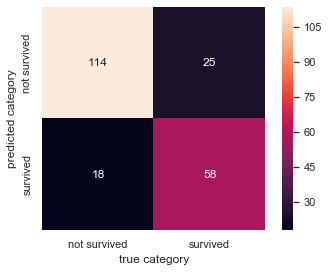

In [25]:
# calculate the confusion matrix. 

mat = confusion_matrix(y_test,y_test2)
print(mat)

#rename data labels: 0 = not survived, 1 = survived
labels = ['not survived','survived']  # keep the alphanumeric order of the original class labels!

# mat.T = transpose the matrix
# data labels (0,1) are sorted from left to right (for the horizontal axis)
# square=True: each cell will be square-shaped
# and from top to bottom (for the vertical axis)
# annot=True: data value in each cell
# fmt='d': format labels as 'double' (not scientific notation)
# cbar=True: color side bar
sns.heatmap(mat.T,square=True, annot=True, fmt='d', cbar=True, xticklabels=labels, yticklabels=labels)
plt.xlabel('true category')
plt.ylabel('predicted category')